In [ ]:
!pip install iglovikov_helper_functions
!pip install cloths_segmentation > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nv

In [ ]:
%matplotlib inline
from pylab import imshow
import albumentations as albu
from pylab import imshow
import numpy as np
import cv2
import torch
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from cloths_segmentation.pre_trained_models import create_model
import matplotlib.pyplot as plt
from PIL import Image


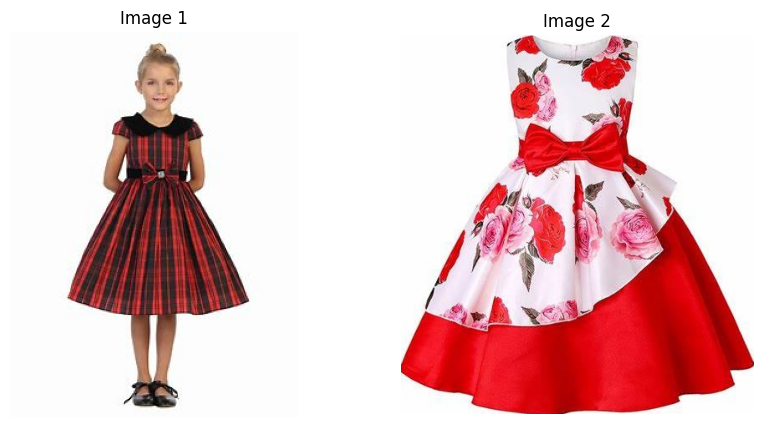

In [ ]:
img_path="/content/OIP (6).jpeg"
dress_path="/content/dressimage1.jpeg"
image1 = Image.open(img_path)
image2 = Image.open(dress_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image1)
axes[0].axis('off')
axes[0].set_title('Image 1')

axes[1].imshow(image2)
axes[1].axis('off')
axes[1].set_title('Image 2')

plt.show()

Downloading: "https://github.com/ternaus/cloths_segmentation/releases/download/0.0.1/weights.zip" to /root/.cache/torch/hub/checkpoints/weights.zip
100%|██████████| 47.0M/47.0M [00:00<00:00, 172MB/s]
/usr/local/lib/python3.10/dist-packages/torch/hub.py:682: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


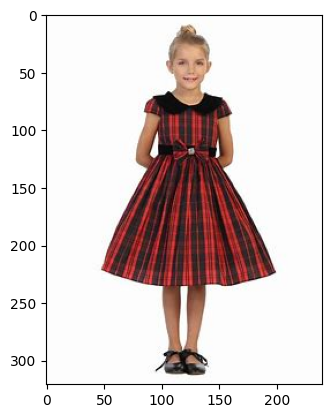

In [ ]:
model =create_model("Unet_2020-10-30")
model.eval();
image=load_rgb(img_path)
imshow(image)

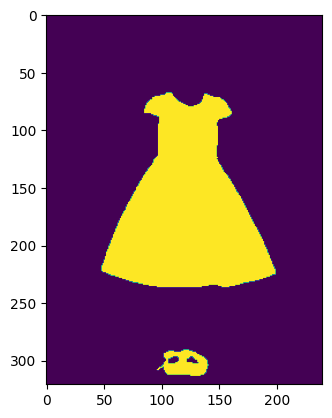

In [ ]:
transform =albu.Compose([albu.Normalize(p=1)], p=1)
padded_image, pads= pad(image, factor=32, border=cv2.BORDER_CONSTANT)
x=transform(image=padded_image) ["image"]
x= torch.unsqueeze(tensor_from_rgb_image(x), 0)
with torch.no_grad():
   prediction= model(x)[0][0]
mask =(prediction > 0).cpu().numpy().astype(np.uint8)
mask= unpad(mask, pads)
imshow(mask)

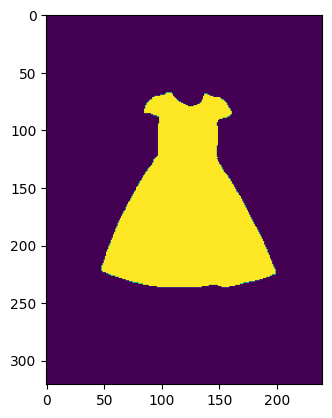

In [ ]:
from PIL import Image
from IPython.display import display
import numpy as np
from skimage.measure import label, regionprops

def find_largest_connected_component(mask):
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)

                                                                      # Finding the largest continous region
    max_area = 0
    largest_component = None
    for region in regions:
        if region.area > max_area:
            max_area = region.area
            largest_component = region

    if largest_component is not None:
        new_mask = np.zeros_like(mask)                                # Ceating a mask
        new_mask[labeled_mask == largest_component.label] = 1
        return new_mask
    else:
        print("No connected components found.")
        return None
new_mask=find_largest_connected_component(mask)
imshow(new_mask)

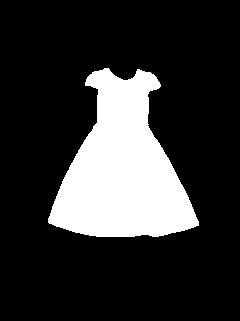

In [ ]:

mask_image = Image.fromarray((new_mask * 255).astype(np.uint8), 'L')
display(mask_image)
mask_image.save("/content/image.png")

In [ ]:

import cv2
import numpy as np
from PIL import Image

def overlay_images(image1_path, image2_path, output_path):

    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)

    # Resize img2 to that of img1
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Convert img2 to RGBA
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGBA)

    # Set the alpha channel to 0 for black pixels in img2
    img2[:, :, 3] = np.where(np.all(img2[:, :, :3] == [0, 0, 0], axis=-1), 0, 255)

    pil_img1 = Image.fromarray(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    pil_img2 = Image.fromarray(img2)
    pil_img1.paste(pil_img2, (0, 0), pil_img2)
    pil_img1.show()
    pil_img1.save(output_path, format='PNG')

image1_path = img_path
image2_path = "/content/image.png"
output_path = '/content/final.jpeg'

overlay_images(image1_path, image2_path, output_path)

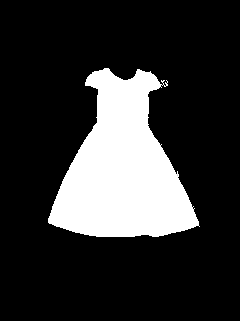

In [ ]:

import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def cut_out_white(image_path, output_path='/content/white_output.png'):
    img = cv2.imread(image_path)

    white_rgb = np.array([255, 255, 255])

    mask = cv2.inRange(img, white_rgb, white_rgb)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_contour_area = 500
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    mask_clean = np.zeros_like(mask)

    cv2.drawContours(mask_clean, valid_contours, -1, (255), thickness=cv2.FILLED)

    cut_out_result = cv2.bitwise_and(img, img, mask=mask_clean)

    cv2_imshow(cut_out_result)
    cv2.imwrite(output_path, cut_out_result)

    return cut_out_result

image_path = '/content/final.jpeg'
cut_out_result = cut_out_white(image_path)


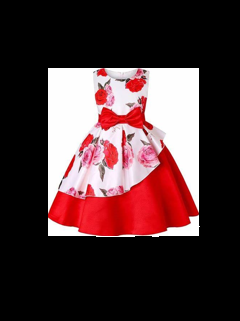

In [15]:

from PIL import Image
from IPython.display import display

def find_white_bounding_box(input_path):

    img = Image.open(input_path)

    img = img.convert("RGBA")


    alpha = img.split()[3]

    # Initialize bounding box
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = 0, 0

    # Iterate over each pixel to find bounding box
    for x in range(img.width):
        for y in range(img.height):
            pixel = img.getpixel((x, y))
            if pixel[:3] == (255, 255, 255):  # Check if the pixel is white
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x)
                max_y = max(max_y, y)

    # Check if any white pixels were found
    if min_x == float('inf') or min_y == float('inf') or max_x == 0 or max_y == 0:
        print("No white pixels found.")
        return None
    else:
        return min_x, min_y, max_x, max_y

def overlay_dress(original_image_path, new_dress_path, output_path):
    # Find the white bounding box in the original image
    bounding_box = find_white_bounding_box(original_image_path)

    if bounding_box is None:
        return

    new_dress = Image.open(new_dress_path)

    # Check if the new dress image has an alpha channel
    if new_dress.mode != "RGBA":
        # If not, create an alpha channel with default value 255 (fully opaque)
        new_dress = new_dress.convert("RGBA")
        alpha = Image.new("L", new_dress.size, 255)
        new_dress.putalpha(alpha)

    # Calculate the dimention of the bounding box
    width = bounding_box[2] - bounding_box[0]
    height = bounding_box[3] - bounding_box[1]
    new_dress = new_dress.resize((width, height))

    # Create a new image with a transparent background
    result = Image.new("RGBA", (new_dress.width, new_dress.height), (0, 0, 0, 0))

    alpha_mask = new_dress.split()[3]

    # Paste the new dress onto the new image using the alpha mask
    result.paste(new_dress, (0, 0), alpha_mask)

    original_image = Image.open(original_image_path)

    original_image.paste(result, (bounding_box[0], bounding_box[1]), result)


    original_image.save(output_path)

    display(original_image)

if __name__ == "__main__":
    original_image_path = "/content/white_output.png"
    new_dress_path = dress_path
    output_path = "/content/image_with_dress.png"


    overlay_dress(original_image_path, new_dress_path, output_path)

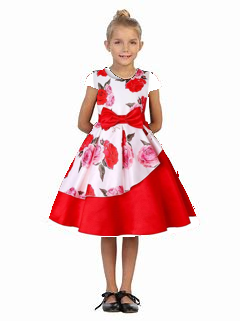

In [16]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def cut_out_white(image_path):

    img = cv2.imread(image_path)

    white_rgb = np.array([255, 255, 255])

    mask = cv2.inRange(img, white_rgb, white_rgb)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 500
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    mask_clean = np.zeros_like(mask)
    cv2.drawContours(mask_clean, valid_contours, -1, (255), thickness=cv2.FILLED)

    cut_out_result = cv2.bitwise_and(img, img, mask=mask_clean)

    non_white_mask = cv2.bitwise_not(mask_clean)

    original_with_non_white = cv2.bitwise_and(img, img, mask=non_white_mask)

    return cut_out_result, original_with_non_white

def find_best_dress_position(original_image, dress_image, mask):
    best_diff = float('inf')
    best_position = (0, 0)
    original_image_resized = cv2.resize(original_image, (dress_image.shape[1], dress_image.shape[0]))

    for y in range(original_image_resized.shape[0] - mask.shape[0] + 1):
        for x in range(original_image_resized.shape[1] - mask.shape[1] + 1):
            mask_full_size = np.zeros_like(original_image_resized[:, :, 0])
            mask_full_size[y:y + mask.shape[0], x:x + mask.shape[1]] = mask
            diff = np.sum(np.abs(original_image_resized - dress_image) * mask_full_size[:, :, None])
            if diff < best_diff:
                best_diff = diff
                best_position = (x, y)

    return best_position

def replace_dress(original_image, dress_image, mask, margin=10):
    best_position = find_best_dress_position(original_image, dress_image, mask)
    y_start = max(0, best_position[1] - margin)
    y_end = min(original_image.shape[0], best_position[1] + mask.shape[0] + 2 * margin)
    x_start = max(0, best_position[0] - margin)
    x_end = min(original_image.shape[1], best_position[0] + mask.shape[1] + 2 * margin)

    dress_image_resized = cv2.resize(dress_image, (x_end - x_start, y_end - y_start))
    mask_full_size = np.zeros_like(original_image[:, :, 0])
    mask_full_size[y_start:y_end, x_start:x_end] = mask
    replaced_image = np.where(mask_full_size[:, :, None] != 0, dress_image_resized, original_image)

    return replaced_image

image_path = '/content/final.jpeg'
dress_path = '/content/image_with_dress.png'

cut_out_white_result, original_with_non_white = cut_out_white(image_path)

dress_image = cv2.imread(dress_path)

final_result = replace_dress(original_with_non_white, dress_image, cut_out_white_result[:, :, 1])

output_path = 'final_result_colab_auto_adjusted.jpg'
cv2.imwrite(output_path, final_result)

cv2_imshow(final_result)
